<a href="https://colab.research.google.com/github/ZefraAlseif/Panda-vs-Dogs-Cats/blob/main/Panda_vs_Cat_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from io import StringIO
from sklearn.preprocessing import LabelEncoder
import sklearn 
from sklearn.model_selection import train_test_split
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import copy
from keras.engine.input_layer import Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from google.colab import files
import os, shutil, pathlib
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import regularizers
from sklearn.utils import validation

# Uploading Kaggle JSon File

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zefraalseif","key":"4d760edb603221467e663ad64da78007"}'}

# Removing/Creating Directory for Kaggle


In [ ]:
!rm -r ~/.kaggle/
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle/': No such file or directory


# Importing Dataset

In [ ]:
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

 93% 351M/376M [00:01<00:00, 275MB/s]
100% 376M/376M [00:01<00:00, 281MB/s]


# Unzipping Dataset

In [ ]:
!unzip -qq animal-image-datasetdog-cat-and-panda.zip

# New Directory Structure

In [ ]:
original_dir = pathlib.Path('animals')
new_base_dir = pathlib.Path('newanim')

def make_subset(subset_name, start_index, end_index):
  for category in ('cats','dogs','panda'):
    dir = new_base_dir / subset_name / category
    dirsrc = original_dir / category
    os.makedirs(dir)
    fnames = ['{}_{:05d}.jpg'.format(category,i) for i in range (start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=dirsrc / fname , dst = dir / fname)

make_subset('train', start_index=1, end_index=701)
make_subset('validation', start_index=701, end_index=901)
make_subset('test', start_index=901,end_index=1001) 

# Remove the Dog DIrectories

In [ ]:
!rm -r ./newanim/train/dogs/
!rm -r ./newanim/validation/dogs/
!rm -r ./newanim/test/dogs/

# Creating TensorFlow Dataset

In [ ]:
train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size = (180,180),
    batch_size = 32)
valdiation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size = (180,180),
    batch_size = 32)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size = (180,180),
    batch_size = 32)

Found 1400 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


# Displaying shape of Dataset

In [ ]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# CNN Model Panda vs Cat (pvcm1)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3,activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
pvcm1 = keras.Model(inputs=inputs, outputs=outputs)

pvcm1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

## Configure Model for Training

In [ ]:
pvcm1.compile(loss = "binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

## Fitting the Model using a Dataset

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="pvcm1.h5",
        save_best_only = True,
        monitor = "val_loss")
]

history1 = pvcm1.fit(
    train_dataset,
    epochs = 11,
    validation_data = valdiation_dataset,
    callbacks = callbacks
)

Epoch 1/11
44/44 [==============================] - 4s 75ms/step - loss: 0.6602 - accuracy: 0.6614 - val_loss: 0.4043 - val_accuracy: 0.8150
Epoch 2/11
44/44 [==============================] - 4s 71ms/step - loss: 0.3809 - accuracy: 0.8386 - val_loss: 0.4951 - val_accuracy: 0.7050
Epoch 3/11
44/44 [==============================] - 4s 72ms/step - loss: 0.3106 - accuracy: 0.8907 - val_loss: 0.3829 - val_accuracy: 0.8525
Epoch 4/11
44/44 [==============================] - 4s 73ms/step - loss: 0.2781 - accuracy: 0.9057 - val_loss: 0.1847 - val_accuracy: 0.9275
Epoch 5/11
44/44 [==============================] - 4s 72ms/step - loss: 0.2475 - accuracy: 0.9093 - val_loss: 0.2636 - val_accuracy: 0.8900
Epoch 6/11
44/44 [==============================] - 4s 72ms/step - loss: 0.1999 - accuracy: 0.9250 - val_loss: 0.3426 - val_accuracy: 0.8825
Epoch 7/11
44/44 [==============================] - 4s 72ms/step - loss: 0.1699 - accuracy: 0.9386 - val_loss: 0.2587 - val_accuracy: 0.9000
Epoch 8/11
44

## Displaying Curves of Loss and Accuracy during Training

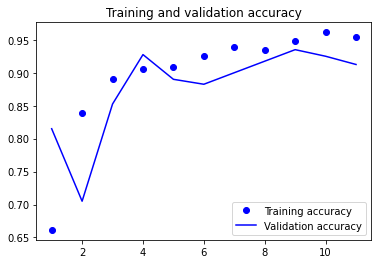

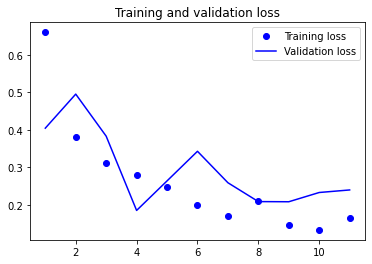

Final Training loss:  0.16530783474445343 
Final Training Accuracy:  0.954285740852356
Final Validation loss:  0.23942400515079498 
Final Validation Accuracy:  0.9125000238418579


In [ ]:
accuracy = history1.history["accuracy"]
val_accuracy = history1.history["val_accuracy"]
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()
# Final Values
print("Final Training loss: ",history1.history['loss'][-1],"\nFinal Training Accuracy: ", history1.history['accuracy'][-1])
print("Final Validation loss: ",history1.history['val_loss'][-1],"\nFinal Validation Accuracy: ", history1.history['val_accuracy'][-1])

## Evaluate Model

In [ ]:
pvcm1.evaluate(test_dataset)

7/7 [==============================] - 0s 12ms/step - loss: 0.3077 - accuracy: 0.9000


[0.30769720673561096, 0.8999999761581421]

# CNN Model 2 Panda vs Cat (w/L2) (pvcm2)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(.25)(x)
x = layers.Conv2D(filters=64, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(.25)(x)
x = layers.Conv2D(filters=128, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(.25)(x)
x = layers.Conv2D(filters=256, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(.25)(x)
x = layers.Conv2D(filters=256, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
pvcm2 = keras.Model(inputs=inputs, outputs=outputs)

pvcm2.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 87, 87, 64)        18496     
                                                          

## Configure Model for Training

In [ ]:
pvcm2.compile(loss = "binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

## Fitting the Model using a Dataset

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="pvcm2.h5",
        save_best_only = True,
        monitor = "val_loss")
]

history2 = pvcm2.fit(
    train_dataset,
    epochs = 14,
    validation_data = valdiation_dataset,
    callbacks = callbacks

)

Epoch 1/14
44/44 [==============================] - 5s 79ms/step - loss: 0.7588 - accuracy: 0.6879 - val_loss: 0.5098 - val_accuracy: 0.8375
Epoch 2/14
44/44 [==============================] - 4s 77ms/step - loss: 0.4986 - accuracy: 0.8014 - val_loss: 0.4564 - val_accuracy: 0.8850
Epoch 3/14
44/44 [==============================] - 4s 77ms/step - loss: 0.3999 - accuracy: 0.8607 - val_loss: 0.4367 - val_accuracy: 0.8475
Epoch 4/14
44/44 [==============================] - 4s 76ms/step - loss: 0.3438 - accuracy: 0.8771 - val_loss: 0.2931 - val_accuracy: 0.8925
Epoch 5/14
44/44 [==============================] - 4s 77ms/step - loss: 0.2792 - accuracy: 0.8993 - val_loss: 0.2765 - val_accuracy: 0.9350
Epoch 6/14
44/44 [==============================] - 4s 75ms/step - loss: 0.3058 - accuracy: 0.9100 - val_loss: 0.4482 - val_accuracy: 0.8175
Epoch 7/14
44/44 [==============================] - 4s 76ms/step - loss: 0.2177 - accuracy: 0.9250 - val_loss: 0.1992 - val_accuracy: 0.9475
Epoch 8/14
44

## Displaying Curves of Loss and Accuracy during Training

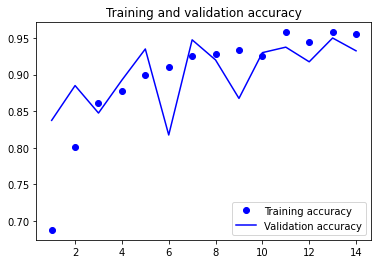

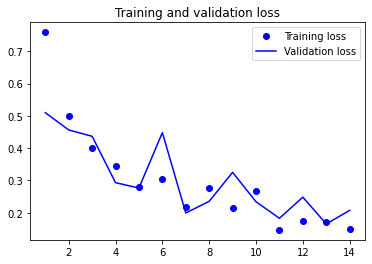

Final Training loss:  0.14952512085437775 
Final Training Accuracy:  0.9557142853736877
Final Validation loss:  0.20736859738826752 
Final Validation Accuracy:  0.9325000047683716


In [ ]:
accuracy = history2.history["accuracy"]
val_accuracy = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()
# Final Values
print("Final Training loss: ",history2.history['loss'][-1],"\nFinal Training Accuracy: ", history2.history['accuracy'][-1])
print("Final Validation loss: ",history2.history['val_loss'][-1],"\nFinal Validation Accuracy: ", history2.history['val_accuracy'][-1])

## Evaluate Model

In [ ]:
pvcm2.evaluate(test_dataset)

7/7 [==============================] - 0s 12ms/step - loss: 0.2329 - accuracy: 0.9300


[0.23292145133018494, 0.9300000071525574]

# CNN Model 3 Panda vs Cat (w/Data Augmentation) (pvcm3)

In [ ]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(.1),
      layers.RandomZoom(.2)
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(.15)(x)
x = layers.Conv2D(filters=64, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(.25)(x)
x = layers.Conv2D(filters=128, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(.5)(x)
x = layers.Conv2D(filters=256, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(.25)(x)
x = layers.Conv2D(filters=256, kernel_size=3, kernel_regularizer=regularizers.l2(.0001),activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
pvcm3 = keras.Model(inputs=inputs, outputs=outputs)

pvcm3.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 89, 89, 32)        0         
                                                          

## Configure Model for Training

In [ ]:
pvcm3.compile(loss = "binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

## Fitting the Model using a Dataset

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="pvcm3.h5",
        save_best_only = True,
        monitor = "val_loss")
]

history3 = pvcm3.fit(
    train_dataset,
    epochs = 65,
    validation_data = valdiation_dataset,
    callbacks = callbacks

)

Epoch 1/65
44/44 [==============================] - 5s 82ms/step - loss: 0.7634 - accuracy: 0.6214 - val_loss: 0.6646 - val_accuracy: 0.7250
Epoch 2/65
44/44 [==============================] - 4s 79ms/step - loss: 0.5590 - accuracy: 0.7493 - val_loss: 0.5065 - val_accuracy: 0.8125
Epoch 3/65
44/44 [==============================] - 4s 79ms/step - loss: 0.4441 - accuracy: 0.8400 - val_loss: 0.3685 - val_accuracy: 0.8475
Epoch 4/65
44/44 [==============================] - 4s 77ms/step - loss: 0.4279 - accuracy: 0.8364 - val_loss: 0.4330 - val_accuracy: 0.8275
Epoch 5/65
44/44 [==============================] - 4s 77ms/step - loss: 0.3739 - accuracy: 0.8643 - val_loss: 0.2952 - val_accuracy: 0.8950
Epoch 6/65
44/44 [==============================] - 4s 77ms/step - loss: 0.3645 - accuracy: 0.8650 - val_loss: 0.2529 - val_accuracy: 0.9000
Epoch 7/65
44/44 [==============================] - 4s 76ms/step - loss: 0.3130 - accuracy: 0.8736 - val_loss: 0.4871 - val_accuracy: 0.8250
Epoch 8/65
44

## Displaying Curves of Loss and Accuracy during Training

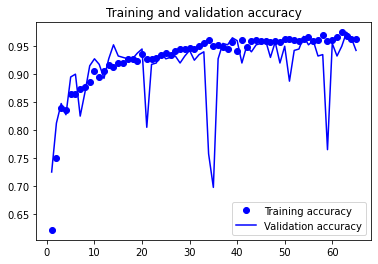

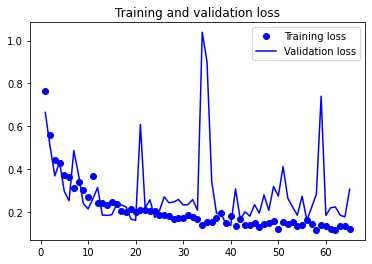

Final Training loss:  0.12229102849960327 
Final Training Accuracy:  0.9628571271896362
Final Validation loss:  0.30623793601989746 
Final Validation Accuracy:  0.9424999952316284


In [ ]:
accuracy = history3.history["accuracy"]
val_accuracy = history3.history["val_accuracy"]
loss = history3.history["loss"]
val_loss = history3.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()
# Final Values
print("Final Training loss: ",history3.history['loss'][-1],"\nFinal Training Accuracy: ", history3.history['accuracy'][-1])
print("Final Validation loss: ",history3.history['val_loss'][-1],"\nFinal Validation Accuracy: ", history3.history['val_accuracy'][-1])

## Evaluate Model

In [ ]:
pvcm3.evaluate(test_dataset)


7/7 [==============================] - 0s 13ms/step - loss: 0.2660 - accuracy: 0.9500


[0.26600533723831177, 0.949999988079071]